## 1. Data Overview
For detailed description, refer to the competetion page.

![data overview](https://storage.googleapis.com/kagglesdsdata/datasets/308369/627264/data_overview.png?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1566501804&Signature=eSwTN5SXDbNeZzPrFTnGNxRIRluacFVt3HOAdJVPoFRNxwA%2FdswsTPcQGj5umyrbP4q%2F86eiDmE446qrQydcjvFE1Pk0%2FneKQZnTkYbajyWNu7TAU2mG2sRedXR59mBaOhJzI7rs8rIF8xaV8WSAcM2etIXM%2BvXg7%2Fmq%2BMIAuDRUnlfVCoxDwJNQoMBZ91ypJnVH4s1Exi335vAWjTGsXR2LNgSKvdw00%2BlVgFSibSnzvi7qvaV4WEPEoZMjDqB3y70lqDz3VrYsf9O%2BUJ4bdFRg5BFDsL%2B0t%2FhWf3oKG2z3L1j8NwoNkeUAitqnWHX3gAe13dkQAe0ovV3J4Cca8g%3D%3D)

## 2. Data import

In [1]:
import os
import copy
import datetime
import warnings

import random
from datetime import datetime
import re

import numpy as np
from scipy.stats import t
import pandas as pd
import keras

from matplotlib import pyplot as plt
import matplotlib as mpl

from wordcloud import WordCloud

import seaborn as sns


Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
np.random.seed(42)

DATA_PATH = '../input/data-science-for-good-careervillage/'
SPLIT_DATE = '2019-01-01'

In [3]:
# Read CSV
answers = pd.read_csv(DATA_PATH+'answers.csv')
answer_scores = pd.read_csv(DATA_PATH+'answer_scores.csv')
comments = pd.read_csv(DATA_PATH+'comments.csv')
emails = pd.read_csv(DATA_PATH+'emails.csv')
groups = pd.read_csv(DATA_PATH+'groups.csv')
group_memberships = pd.read_csv(DATA_PATH+ 'group_memberships.csv')
matches = pd.read_csv(DATA_PATH+ 'matches.csv')
professionals = pd.read_csv(DATA_PATH +'professionals.csv')
questions = pd.read_csv(DATA_PATH+ 'questions.csv')
question_scores = pd.read_csv(DATA_PATH+'question_scores.csv')
school_memberships = pd.read_csv(DATA_PATH +'school_memberships.csv')
students = pd.read_csv(DATA_PATH+ 'students.csv')
tags = pd.read_csv(DATA_PATH+ 'tags.csv')
tag_questions = pd.read_csv(DATA_PATH +'tag_questions.csv')
tag_users = pd.read_csv(DATA_PATH+ 'tag_users.csv')

## 3. Data processing

In [4]:
# Convert datetime format
answers['answers_date_added'] = pd.to_datetime(answers['answers_date_added'], infer_datetime_format=True)
comments['comments_date_added'] = pd.to_datetime(comments['comments_date_added'], infer_datetime_format=True)
emails['emails_date_sent'] = pd.to_datetime(emails['emails_date_sent'], infer_datetime_format=True)
professionals['professionals_date_joined'] = pd.to_datetime(professionals['professionals_date_joined'], infer_datetime_format=True)
questions['questions_date_added'] = pd.to_datetime(questions['questions_date_added'], infer_datetime_format=True)
students['students_date_joined'] = pd.to_datetime(students['students_date_joined'], infer_datetime_format=True)

In [5]:
# Get the first and last date of activities for each professionals and students

# Answer activity
temp = answers.groupby('answers_author_id').max()['answers_date_added']
professionals = professionals.merge(pd.DataFrame(temp.rename('last_answer')),\
                                    left_on='professionals_id',right_index=True,how='left')
temp = answers.groupby('answers_author_id').min()['answers_date_added']
professionals = professionals.merge(pd.DataFrame(temp.rename('first_answer')),\
                                    left_on='professionals_id',right_index=True,how='left')
# Question activity
temp = questions.groupby('questions_author_id').max()['questions_date_added']
students = students.merge(pd.DataFrame(temp.rename('last_question')),\
                                    left_on='students_id',right_index=True,how='left')
temp = questions.groupby('questions_author_id').min()['questions_date_added']
students = students.merge(pd.DataFrame(temp.rename('first_question')),\
                                    left_on='students_id',right_index=True,how='left')
# Comment activity
temp = comments.groupby('comments_author_id').max()['comments_date_added']
students = students.merge(pd.DataFrame(temp.rename('last_comment')),\
                                    left_on='students_id',right_index=True,how='left')
professionals = professionals.merge(pd.DataFrame(temp.rename('last_comment')),\
                                    left_on='professionals_id',right_index=True,how='left')
temp = comments.groupby('comments_author_id').min()['comments_date_added']
students = students.merge(pd.DataFrame(temp.rename('first_comment')),\
                                    left_on='students_id',right_index=True,how='left')
professionals = professionals.merge(pd.DataFrame(temp.rename('first_comment')),\
                                    left_on='professionals_id',right_index=True,how='left')


## 4. EDA

### 4.1 Data consumption overview
* Professionals: Location, Industry, Headline, Tags, Groups, Schools, Answers, and Comments,
* Students: Location, Tags, Groups, Schools, Questions, and Comments,

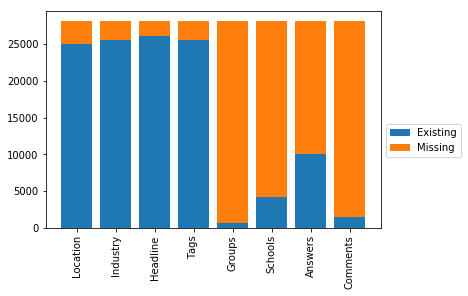

In [6]:
# Professionals
xTick=['Location','Industry', 'Headline', 'Tags', 'Groups', 'Schools', 'Answers', 'Comments']
xidx=range(len(xTick))
total=professionals.shape[0]
yNMiss = []
# Location
yNMiss.append(professionals['professionals_location'].count())
# Industry
yNMiss.append(professionals['professionals_industry'].count())
# Headline
yNMiss.append(professionals['professionals_headline'].count())
# Tags
temp=tag_users.groupby('tag_users_user_id').min()['tag_users_tag_id']
yNMiss.append(professionals.merge(pd.DataFrame(temp),left_on='professionals_id',\
                                  right_index=True,how='left')['tag_users_tag_id'].count())
# Groups
yNMiss.append(professionals.merge(group_memberships,left_on='professionals_id',\
                                  right_on='group_memberships_user_id',how='left')['group_memberships_group_id'].count())
# Schools
yNMiss.append(professionals.merge(school_memberships,left_on='professionals_id',\
                                  right_on='school_memberships_user_id',how='left')['school_memberships_school_id'].count())
# Answers
yNMiss.append(professionals['first_answer'].count())
# Comments
yNMiss.append(professionals['first_comment'].count())

# Plot
yMiss = [total-x for x in yNMiss]
p1=plt.bar(xidx,yNMiss)
p2=plt.bar(xidx,yMiss,bottom=yNMiss)
plt.xticks(xidx, xTick, rotation='vertical')
plt.legend((p1[0],p2[0]),('Existing','Missing'),bbox_to_anchor=(1,.5))
plt.show()

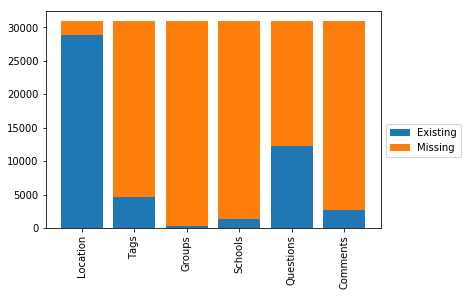

In [7]:
# Students
xTick=['Location','Tags', 'Groups', 'Schools', 'Questions', 'Comments']
xidx=range(len(xTick))
total=students.shape[0]
yNMiss = []
# Location
yNMiss.append(students['students_location'].count())
# Tags
temp=tag_users.groupby('tag_users_user_id').min()['tag_users_tag_id']
yNMiss.append(students.merge(pd.DataFrame(temp),left_on='students_id',\
                                  right_index=True,how='left')['tag_users_tag_id'].count())
# Groups
yNMiss.append(students.merge(group_memberships,left_on='students_id',\
                                  right_on='group_memberships_user_id',how='left')['group_memberships_group_id'].count())
# Schools
yNMiss.append(students.merge(school_memberships,left_on='students_id',\
                                  right_on='school_memberships_user_id',how='left')['school_memberships_school_id'].count())
# Answers
yNMiss.append(students['first_question'].count())
# Comments
yNMiss.append(students['first_comment'].count())

# Plot
yMiss = [total-x for x in yNMiss]
p1=plt.bar(xidx,yNMiss)
p2=plt.bar(xidx,yMiss,bottom=yNMiss)
plt.xticks(xidx, xTick, rotation='vertical')
plt.legend((p1[0],p2[0]),('Existing','Missing'),bbox_to_anchor=(1,.5))
plt.show()

### 4.2 Locations distribution


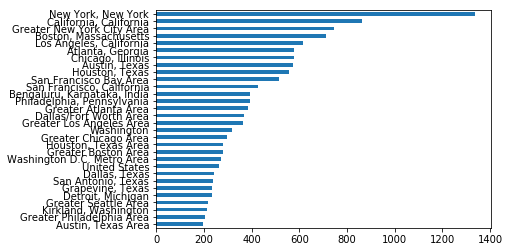

In [8]:
# Professionals
professionals['professionals_location'].value_counts(ascending=True).tail(30).plot.barh()
plt.show()

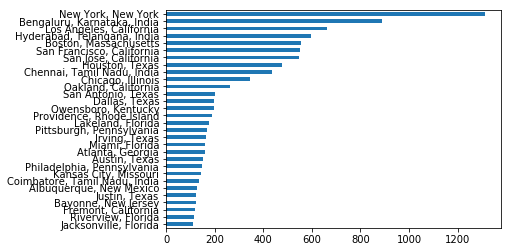

In [9]:
# Students
students['students_location'].value_counts(ascending=True).tail(30).plot.barh()
plt.show()

### 4.3 Users registered per year


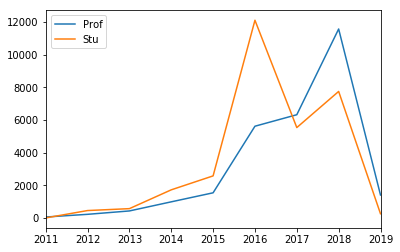

In [10]:
pd.DataFrame({'Prof':professionals['professionals_date_joined'].dt.year.value_counts().sort_index(),\
              'Stu':students['students_date_joined'].dt.year.value_counts().sort_index()}).plot()
plt.show()

### 4.4 Questions & answers posted per year

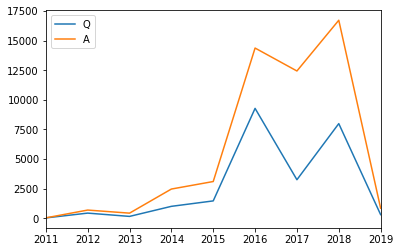

In [11]:
pd.DataFrame({'Q':questions['questions_date_added'].dt.year.value_counts().sort_index(),\
              'A':answers['answers_date_added'].dt.year.value_counts().sort_index()}).plot()
plt.show()

### 4.5 Student-Questions & Professional-Answers count distributions

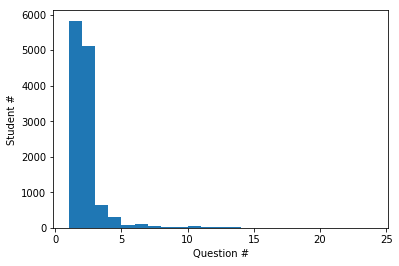

In [12]:
# S-Q distribution
questions['questions_author_id'].value_counts().hist(bins=range(1,25),grid=False)
plt.xlabel('Question #')
plt.ylabel('Student #')
plt.show()

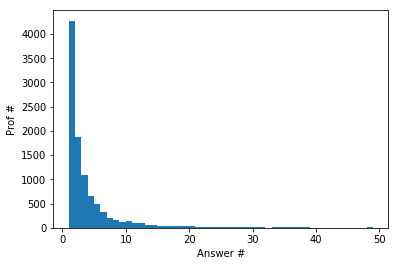

In [13]:
# P-A distribution
answers['answers_author_id'].value_counts().hist(bins=range(1,50),grid=False)
plt.xlabel('Answer #')
plt.ylabel('Prof #')
plt.show()

### 4.6 Question-Answer cont distribution

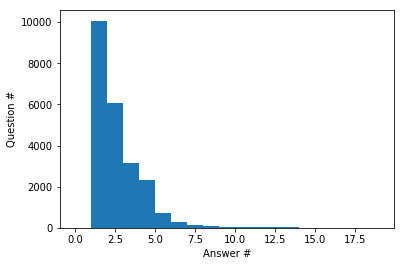

In [14]:
answers['answers_question_id'].value_counts().hist(bins=range(0,20),grid=False)
plt.xlabel('Answer #')
plt.ylabel('Question #')
plt.show()

### 4.7 Top tags in questions

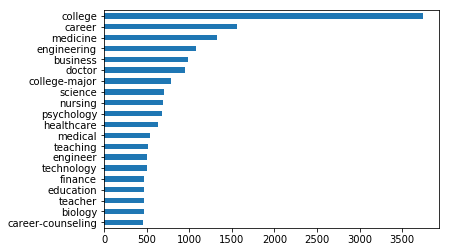

In [15]:
tag_questions.merge(tags,left_on='tag_questions_tag_id',right_on='tags_tag_id',how='left')['tags_tag_name']\
            .value_counts(ascending=True).tail(20).plot.barh()
plt.show()

### 4.8 Top tags in students

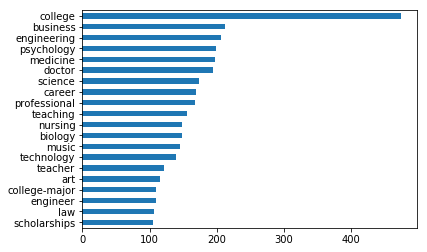

In [16]:
tag_users[tag_users['tag_users_user_id'].isin(students['students_id'])]\
        .merge(tags,left_on='tag_users_tag_id',right_on='tags_tag_id',how='left')['tags_tag_name']\
        .value_counts(ascending=True).tail(20).plot.barh()
plt.show()

### 4.9 Top tags in professionals

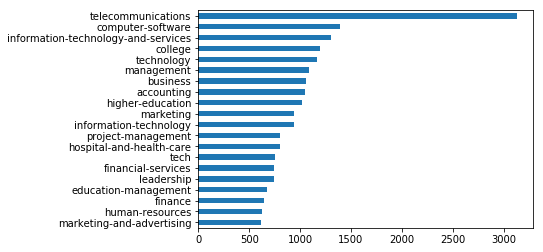

In [17]:
tag_users[tag_users['tag_users_user_id'].isin(professionals['professionals_id'])]\
        .merge(tags,left_on='tag_users_tag_id',right_on='tags_tag_id',how='left')['tags_tag_name']\
        .value_counts(ascending=True).tail(20).plot.barh()
plt.show()

### 4.10 Average question response days per year

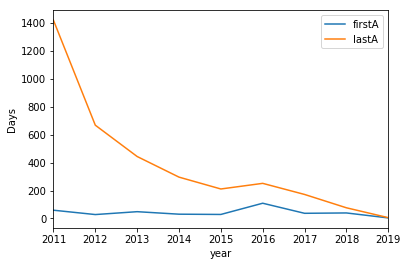

In [18]:
afirst = answers.groupby('answers_question_id').min()['answers_date_added'].rename('firstA')
alast = answers.groupby('answers_question_id').max()['answers_date_added'].rename('lastA')
temp = questions.merge(pd.DataFrame(afirst),left_on='questions_id',right_index=True,how='left')\
            .merge(pd.DataFrame(alast),left_on='questions_id',right_index=True,how='left')[['questions_date_added','firstA','lastA']]
temp['firstA']=(temp['firstA']-temp['questions_date_added']).dt.days
temp['lastA']=(temp['lastA']-temp['questions_date_added']).dt.days
temp['year']=temp['questions_date_added'].dt.year
temp.groupby('year').mean().plot()
plt.ylabel('Days')
plt.show()

### 4.11 Emails per year

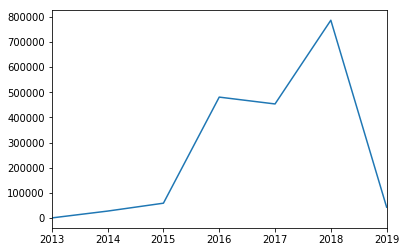

In [19]:
emails['emails_date_sent'].dt.year.value_counts().sort_index().plot()
plt.show()

### 4.12 Questions-email distribution

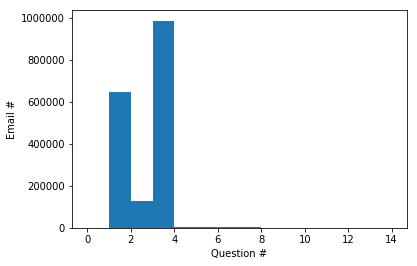

In [20]:
matches.groupby('matches_email_id').size().hist(bins=range(15),grid=False)
plt.xlabel('Question #')
plt.ylabel('Email #')
plt.show()

## 5. NLP

Build a LDA model on the full question text (headline+body). Given a new question, find the most similar question and get the professionals who answered that question. 

### 5.1 Process training data

In [21]:
import spacy

In [22]:
# Create full text for questions
testData = questions.head(100)
testData['full_txt'] = testData['questions_title']+' '+testData['questions_body']
testData['full_txt']= testData['full_txt'].str.replace('#',' ')

# Apply spaCy part-of-speech to tokenize the text
token_pos = ['NOUN', 'VERB', 'PROPN', 'ADJ', 'INTJ', 'X']
nlp = spacy.load("en_core_web_sm")
dpipe = nlp.pipe(testData['full_txt'],disable=["parser","ner"])
tokens=[]
for doc in dpipe:
    tokens.append([t.lower_ for t in doc if (t.pos_ in token_pos and not t.is_stop and t.is_alpha)])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### 5.2 Train LDA model

In [23]:
import gensim

In [24]:
# Create Gensim dic from the tokens
no_below = 20
no_above = 0.6
keep_n = 8000
lda_dic = gensim.corpora.Dictionary(tokens)
##lda_dic.filter_extremes(no_below=no_below, no_above=no_above, keep_n=keep_n)

# Create corpus from the dic
lda_corpus = [lda_dic.doc2bow(doc) for doc in tokens]

# Create tf-idf from corpus
tfidf = gensim.models.TfidfModel(lda_corpus)
tfidf_corpus = tfidf[lda_corpus]

# Train model
num_topics = 19
passes = 15
chunksize = 1000
alpha = 1/50
seed=13
lda_model = gensim.models.ldamodel.LdaModel(tfidf_corpus, num_topics=num_topics, \
                                            id2word = lda_dic, passes=passes,\
                                            chunksize=chunksize,update_every=0,\
                                            alpha=alpha, random_state=seed)

### 5.3 Find similar questions and corresponding professionals

In [25]:
# Convert the query to LDA space
doc = "I would love to be a civil engineer one day"
vec_bow = lda_dic.doc2bow(doc.lower().split())
vec_corpus = tfidf[vec_bow]
vec_lda = lda_model[vec_corpus] 

# Transform tfidf corpus to LDA space and index it
index = gensim.similarities.MatrixSimilarity(lda_model[tfidf_corpus])

# Perform a similarity query against the tfidf corpus
sims = index[vec_lda]  
sims = sorted(enumerate(sims), key=lambda item: -item[1])

# Get the most similar question
q_id = testData['questions_id'][sims[0][0]]
print(testData.iloc[sims[0][0]])
print(testData['full_txt'][sims[0][0]])

# Get the professionals
prof_id = answers['answers_author_id'][answers['answers_question_id']==q_id]
print(prof_id)

questions_id                             63171d8c2d3f4a8c9100b0bfcb062195
questions_author_id                      240a5e4e4acd469b936e1a091232ceb0
questions_date_added                                  2016-10-25 21:09:04
questions_title         As a civil engineer, what percent of your time...
questions_body          I would love to be a civil engineer one day. I...
full_txt                As a civil engineer, what percent of your time...
Name: 12, dtype: object
As a civil engineer, what percent of your time would you say per week you spend on site helping to organize construction efforts and people and what percent of your time do you spend in an office making calculation and coming up with designs? I would love to be a civil engineer one day. I definitely don't want to be a construction worker and spend all day outside working with tools and building things but I also wouldn't want a 10 hour a day desk job. Civil engineer seems like a happy medium and I just wondered from a professi